In [1]:
from keras.losses import SparseCategoricalCrossentropy
import zipfile
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import (Rescaling,Reshape,Resizing,InputLayer,MaxPool2D,AveragePooling2D,GlobalAveragePooling2D,Conv2D,
                                     Flatten,Dropout,BatchNormalization,Dense)
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.metrics import (Accuracy,SparseCategoricalAccuracy,CategoricalAccuracy,TopKCategoricalAccuracy)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aksh2704","key":"6775788223fc875ad4415ea43b797876"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 May 31 11:01 kaggle.json


In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 96% 297M/309M [00:02<00:00, 102MB/s]
100% 309M/309M [00:02<00:00, 117MB/s]


In [8]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [9]:
train_datapath="/content/dataset/Emotions Dataset/Emotions Dataset/train/"
val_datapath="/content/dataset/Emotions Dataset/Emotions Dataset/test/"
CLASS_NAME=["angry","happy","sad"]

In [10]:
CONFIGURATION={
    "BATCH_SIZE":32,
    "IMG_SIZE":256,
    "CLASS_NAMES": ["angry", "happy", "sad"],
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0,
    "N_FILTERS": 16,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,

}

##**Dataset Loading**

In [11]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    directory=train_datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [12]:
val_dataset=tf.keras.utils.image_dataset_from_directory(
    directory=val_datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


##**Dataset Preperation**

In [13]:
training_dataset=(
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
val_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [15]:
training_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [16]:
print(len(train_dataset))

213


In [17]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
print(len(val_dataset))

72


In [19]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
       Rescaling(1./255),                 
])

##**Dataset Visualization**

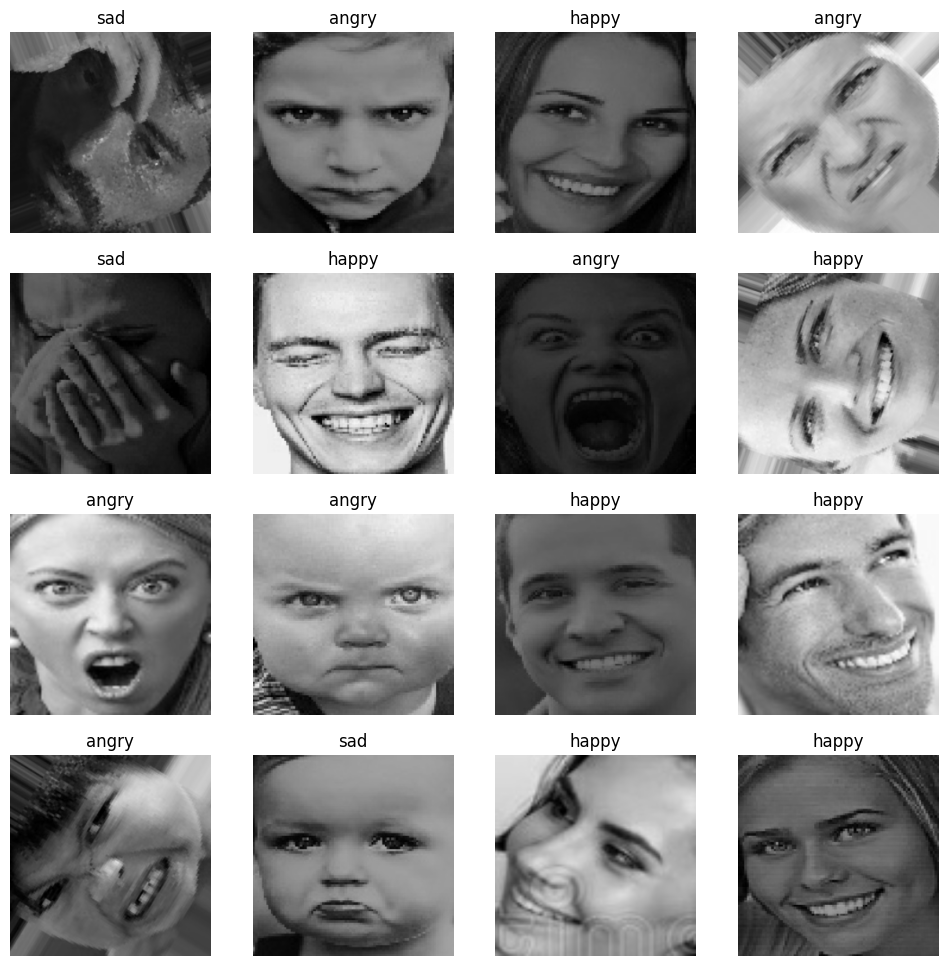

In [20]:
plt.figure(figsize=(12,12))

for image,labels in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i],axis=-1).numpy()])
    plt.axis("off")

In [21]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 36)     

In [22]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [23]:
lenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]),
                    metrics=["accuracy"])

In [24]:
for name,label in training_dataset.take(1):
  print(len(label.shape))

2


In [25]:
history_1=lenet_model.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10
213/213 [==============================] - 38s 96ms/step - loss: 9.6618 - accuracy: 0.4642 - val_loss: 1.7349 - val_accuracy: 0.3714
Epoch 2/10
213/213 [==============================] - 21s 97ms/step - loss: 1.0465 - accuracy: 0.4833 - val_loss: 1.4903 - val_accuracy: 0.4526
Epoch 3/10
213/213 [==============================] - 22s 101ms/step - loss: 0.9750 - accuracy: 0.5182 - val_loss: 3.0366 - val_accuracy: 0.3859
Epoch 4/10
213/213 [==============================] - 20s 93ms/step - loss: 0.9205 - accuracy: 0.5396 - val_loss: 1.0788 - val_accuracy: 0.4794
Epoch 5/10
213/213 [==============================] - 21s 95ms/step - loss: 0.8724 - accuracy: 0.5805 - val_loss: 0.9780 - val_accuracy: 0.5013
Epoch 6/10
213/213 [==============================] - 21s 98ms/step - loss: 0.7915 - accuracy: 0.6167 - val_loss: 1.1559 - val_accuracy: 0.5882
Epoch 7/10
213/213 [==============================] - 20s 94ms/step - loss: 0.6842 - accuracy: 0.6511 - val_loss: 1.0006 - val_accuracy

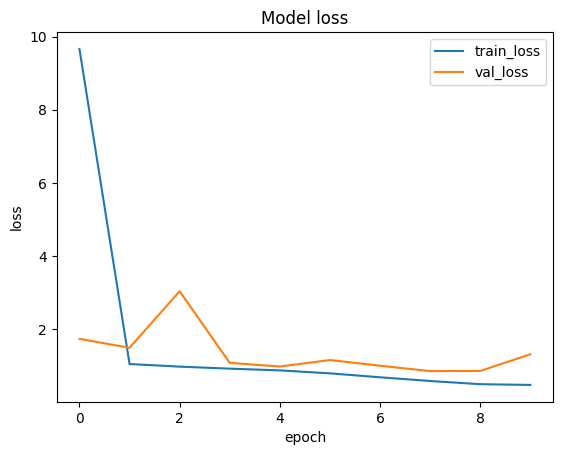

In [26]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

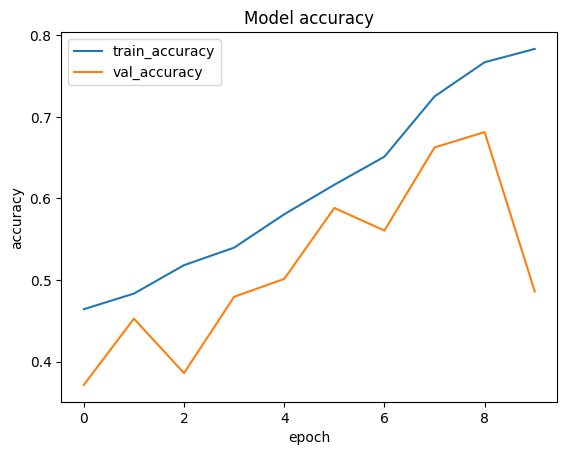

In [27]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [28]:
evaluate=lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 36ms/step - loss: 1.3127 - accuracy: 0.4860


##**Testing Image**

In [29]:

from google.colab.patches import cv2_imshow
test_image=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/126093.jpg")

img=tf.constant(test_image,dtype=tf.float32)
img=tf.expand_dims(img,axis=0)
label=lenet_model(img)
print(label)
prediction=CLASS_NAME[tf.argmax(label,axis=-1).numpy()[0]]
prediction

tf.Tensor([[0.25243813 0.6619289  0.08563298]], shape=(1, 3), dtype=float32)


'happy'

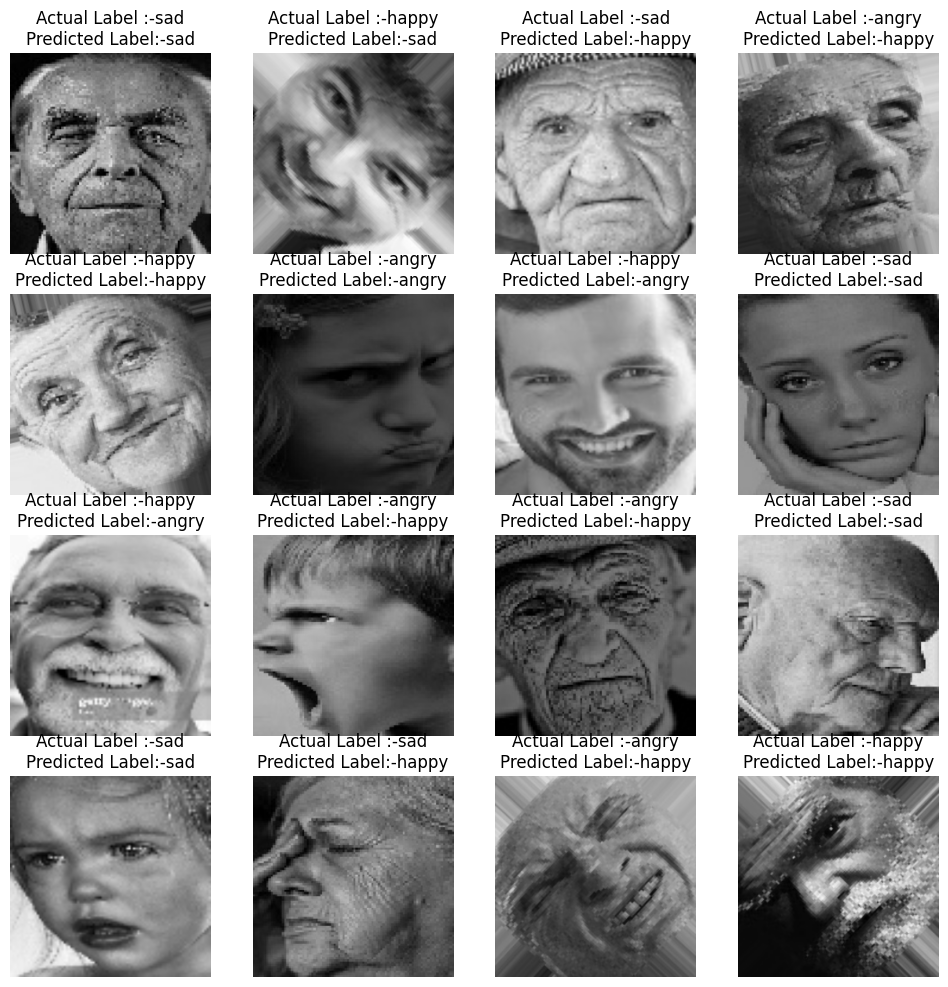

In [30]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [31]:
preds=[]
actual=[]

for im,label in val_dataset:
  actual.append(label.numpy())
  preds.append(lenet_model(im).numpy())

In [32]:
print(np.argmax(preds[:-1],axis=-1).flatten())
print(np.argmax(actual[:-1],axis=-1).flatten())

[1 0 2 ... 2 1 1]
[1 0 2 ... 0 1 2]


In [33]:
preds=np.concatenate((np.argmax(preds[:-1],axis=-1).flatten(),(np.argmax(preds[-1],axis=-1).flatten())),axis=0)
labels=np.concatenate((np.argmax(actual[:-1],axis=-1).flatten(),np.argmax(actual[-1],axis=-1).flatten()),axis=0)

In [34]:

preds.shape

(2278,)

In [35]:
labels.shape

(2278,)

In [36]:
cm=confusion_matrix(labels,preds)
print(cm)

[[379  92  44]
 [511 438  57]
 [301 166 290]]


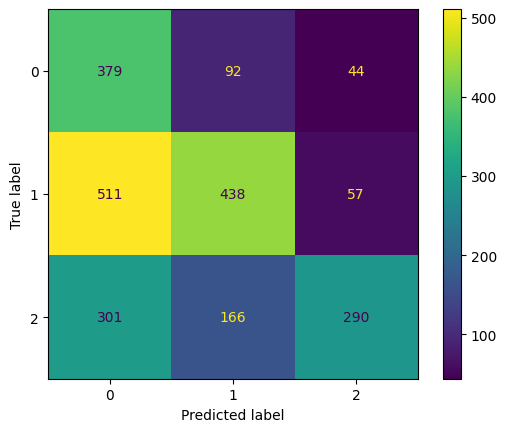

In [37]:
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

##**Improving score by Data Augmentation**

In [38]:
augment_layers = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [39]:
def augment_layer(image,label):
  return augment_layers(image,training=True),label

In [40]:
training_dataset_aug=(
    train_dataset
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [41]:
val_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [42]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
       Rescaling(1./255),                 
])

##**Dataset Visualization**

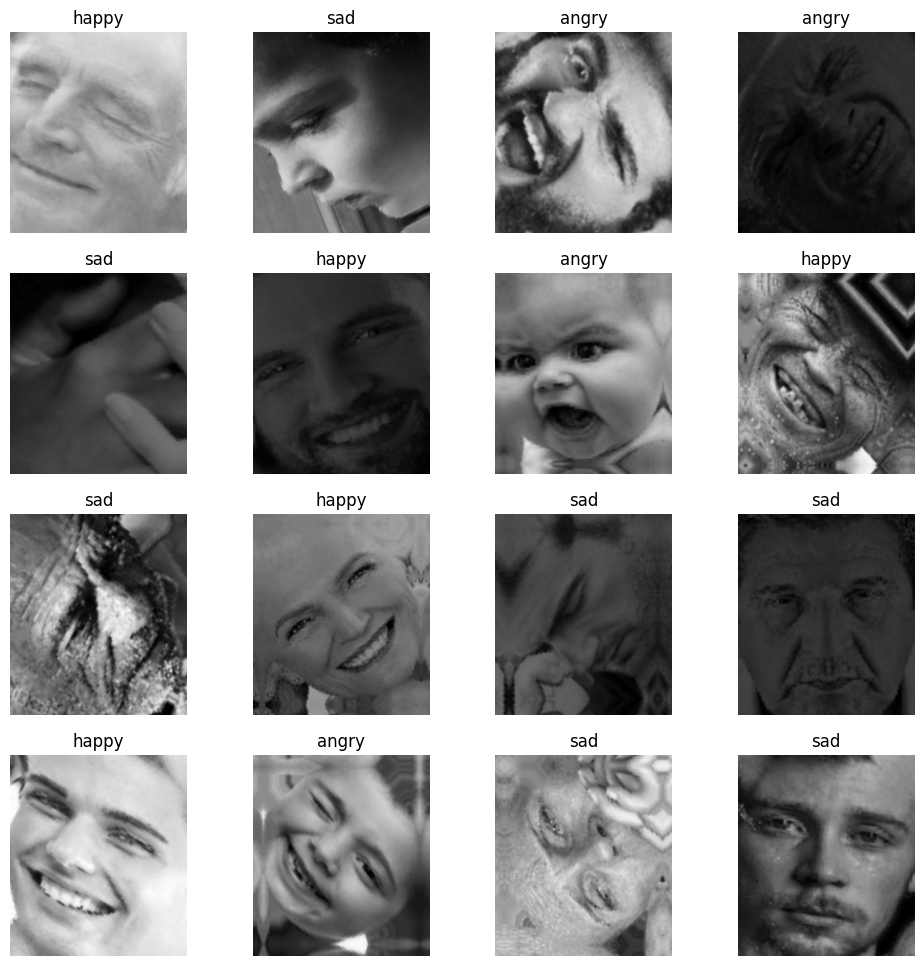

In [43]:
plt.figure(figsize=(12,12))

for image,labels in training_dataset_aug.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i],axis=-1).numpy()])
    plt.axis("off")

In [44]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= 2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_2 (Batc  (None, 254, 254, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 36)     

In [45]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [46]:
lenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]),
                    metrics=["accuracy"])

In [47]:
for name,label in training_dataset_aug.take(1):
  print(len(label))

32


In [48]:
history_2=lenet_model.fit(training_dataset_aug,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10
213/213 [==============================] - 84s 376ms/step - loss: 9.1511 - accuracy: 0.4277 - val_loss: 2.0165 - val_accuracy: 0.4324
Epoch 2/10
213/213 [==============================] - 82s 378ms/step - loss: 1.0450 - accuracy: 0.4467 - val_loss: 1.6235 - val_accuracy: 0.4025
Epoch 3/10
213/213 [==============================] - 83s 386ms/step - loss: 1.0063 - accuracy: 0.4776 - val_loss: 1.0064 - val_accuracy: 0.4996
Epoch 4/10
213/213 [==============================] - 81s 379ms/step - loss: 0.9964 - accuracy: 0.5052 - val_loss: 0.9744 - val_accuracy: 0.5127
Epoch 5/10
213/213 [==============================] - 82s 384ms/step - loss: 1.0012 - accuracy: 0.4793 - val_loss: 2.6904 - val_accuracy: 0.5219
Epoch 6/10
213/213 [==============================] - 82s 381ms/step - loss: 1.0464 - accuracy: 0.4977 - val_loss: 0.9779 - val_accuracy: 0.5193
Epoch 7/10
213/213 [==============================] - 81s 377ms/step - loss: 0.9760 - accuracy: 0.5127 - val_loss: 1.3284 - val_ac

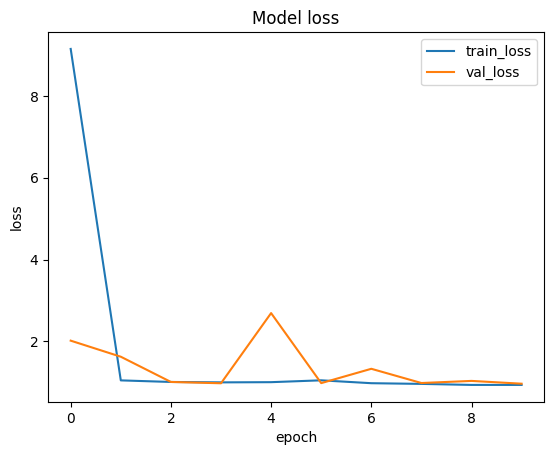

In [49]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

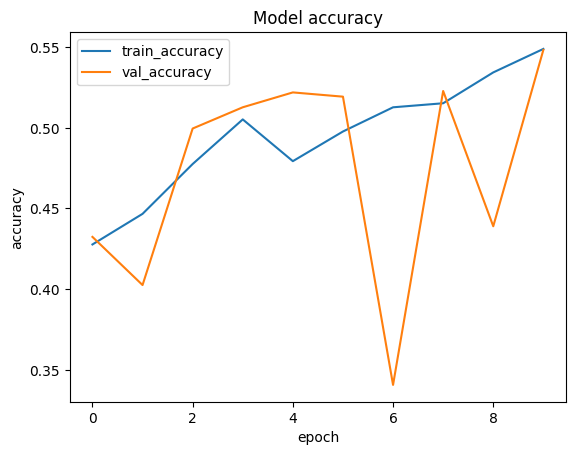

In [50]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [51]:
evaluate=lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 36ms/step - loss: 0.9639 - accuracy: 0.5483


##**Testing Image**

In [52]:

from google.colab.patches import cv2_imshow
test_image=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/126093.jpg")

img=tf.constant(test_image,dtype=tf.float32)
img=tf.expand_dims(img,axis=0)
label=lenet_model(img)
print(label)
prediction=CLASS_NAME[tf.argmax(label,axis=-1).numpy()[0]]
prediction

tf.Tensor([[0.00323078 0.9762298  0.02053936]], shape=(1, 3), dtype=float32)


'happy'

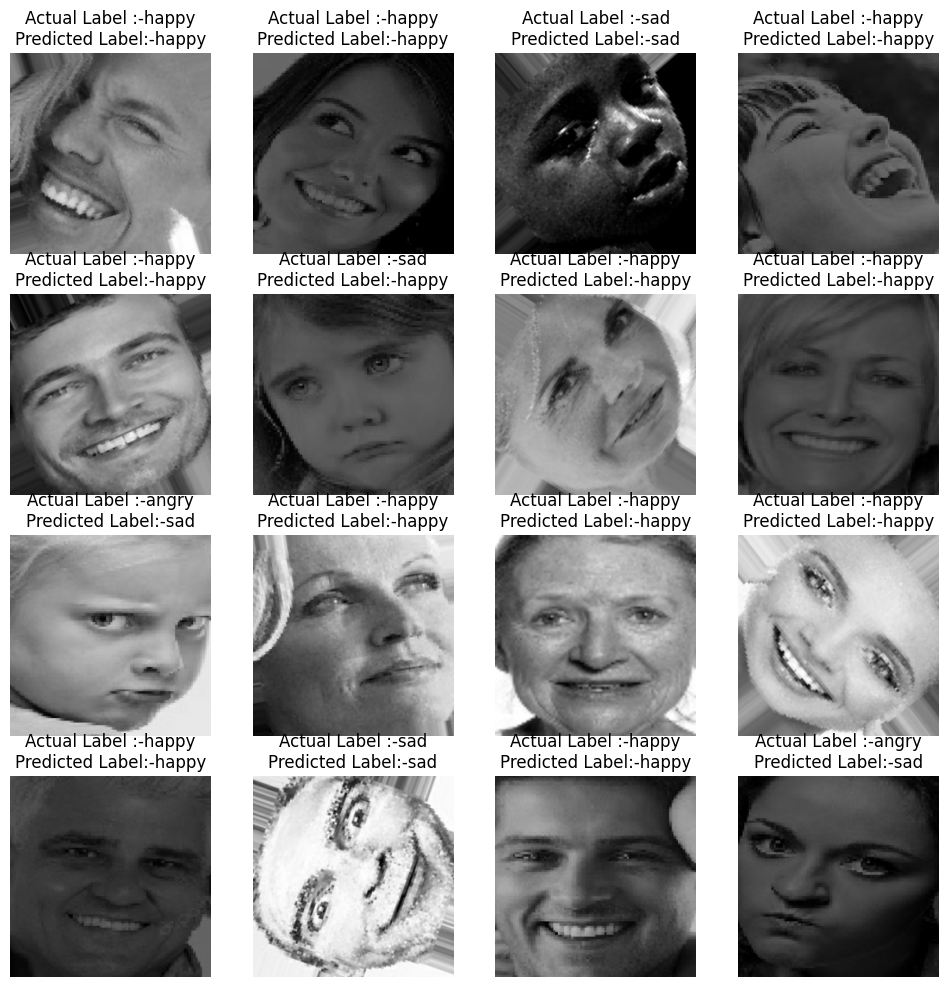

In [53]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [54]:
preds=[]
actual=[]

for im,label in val_dataset:
  actual.append(label.numpy())
  preds.append(lenet_model(im).numpy())

In [55]:
print(np.argmax(preds[:-1],axis=-1).flatten())
print(np.argmax(actual[:-1],axis=-1).flatten())

[2 2 1 ... 2 2 1]
[2 2 1 ... 0 2 2]


In [56]:
preds=np.concatenate((np.argmax(preds[:-1],axis=-1).flatten(),(np.argmax(preds[-1],axis=-1).flatten())),axis=0)
labels=np.concatenate((np.argmax(actual[:-1],axis=-1).flatten(),np.argmax(actual[-1],axis=-1).flatten()),axis=0)

In [57]:

preds.shape

(2278,)

In [58]:
labels.shape

(2278,)

In [59]:
cm=confusion_matrix(labels,preds)
print(cm)

[[  2 157 356]
 [  0 715 291]
 [  1 224 532]]


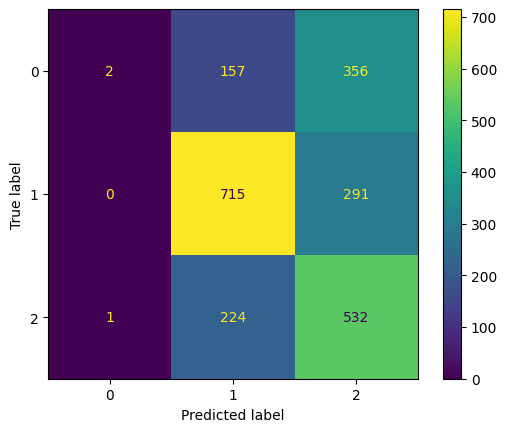

In [60]:
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

###**Model perform poorly with data augmentation**

##**Custom Resnet Model**

In [61]:
class CustomConv2D(tf.keras.layers.Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### Residual Block

In [62]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = tf.keras.layers.Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = tf.keras.layers.Add()([x, x_add])
    else:
      x_add =tf.keras.layers.Add()([x, input])

    return self.activation(x_add)


### Complete Network

In [63]:
class ResNet34(tf.keras.Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = tf.keras.layers.MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
    
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    
    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    
    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)
    
    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [64]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

In [65]:
resnet_34.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]*10),
                    metrics=["accuracy"])

In [66]:
for name,label in training_dataset.take(1):
  print(len(label))

32


In [67]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_weights', 
    monitor='val_accuracy',
    mode = 'max',
    verbose=1, 
    save_best_only=True,
    
    )

In [68]:
history_3=resnet_34.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=[checkpoint_callback])

Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 1.4668 - accuracy: 0.4409
Epoch 1: val_accuracy improved from -inf to 0.40650, saving model to best_weights


213/213 [==============================] - 95s 318ms/step - loss: 1.4668 - accuracy: 0.4409 - val_loss: 2.0421 - val_accuracy: 0.4065
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.4942
Epoch 2: val_accuracy improved from 0.40650 to 0.49737, saving model to best_weights


213/213 [==============================] - 66s 308ms/step - loss: 1.1028 - accuracy: 0.4942 - val_loss: 1.1165 - val_accuracy: 0.4974
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 1.0124 - accuracy: 0.5292
Epoch 3: val_accuracy improved from 0.49737 to 0.51975, saving model to best_weights


213/213 [==============================] - 67s 313ms/step - loss: 1.0124 - accuracy: 0.5292 - val_loss: 1.2270 - val_accuracy: 0.5198
Epoch 4/10
213/213 [==============================] - ETA: 0s - loss: 0.9755 - accuracy: 0.5567
Epoch 4: val_accuracy improved from 0.51975 to 0.53644, saving model to best_weights


213/213 [==============================] - 71s 330ms/step - loss: 0.9755 - accuracy: 0.5567 - val_loss: 1.1012 - val_accuracy: 0.5364
Epoch 5/10
213/213 [==============================] - ETA: 0s - loss: 0.9554 - accuracy: 0.5639
Epoch 5: val_accuracy did not improve from 0.53644
213/213 [==============================] - 49s 227ms/step - loss: 0.9554 - accuracy: 0.5639 - val_loss: 1.1155 - val_accuracy: 0.4987
Epoch 6/10
213/213 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.5779
Epoch 6: val_accuracy did not improve from 0.53644
213/213 [==============================] - 51s 237ms/step - loss: 0.9112 - accuracy: 0.5779 - val_loss: 1.3317 - val_accuracy: 0.3780
Epoch 7/10
213/213 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.5963
Epoch 7: val_accuracy improved from 0.53644 to 0.57419, saving model to best_weights


213/213 [==============================] - 67s 314ms/step - loss: 0.8952 - accuracy: 0.5963 - val_loss: 0.9449 - val_accuracy: 0.5742
Epoch 8/10
213/213 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6111
Epoch 8: val_accuracy did not improve from 0.57419
213/213 [==============================] - 49s 229ms/step - loss: 0.8717 - accuracy: 0.6111 - val_loss: 1.5008 - val_accuracy: 0.4741
Epoch 9/10
213/213 [==============================] - ETA: 0s - loss: 0.8559 - accuracy: 0.6126
Epoch 9: val_accuracy did not improve from 0.57419
213/213 [==============================] - 49s 230ms/step - loss: 0.8559 - accuracy: 0.6126 - val_loss: 0.9611 - val_accuracy: 0.5623
Epoch 10/10
213/213 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.6420
Epoch 10: val_accuracy improved from 0.57419 to 0.58297, saving model to best_weights


213/213 [==============================] - 71s 335ms/step - loss: 0.8096 - accuracy: 0.6420 - val_loss: 0.9877 - val_accuracy: 0.5830


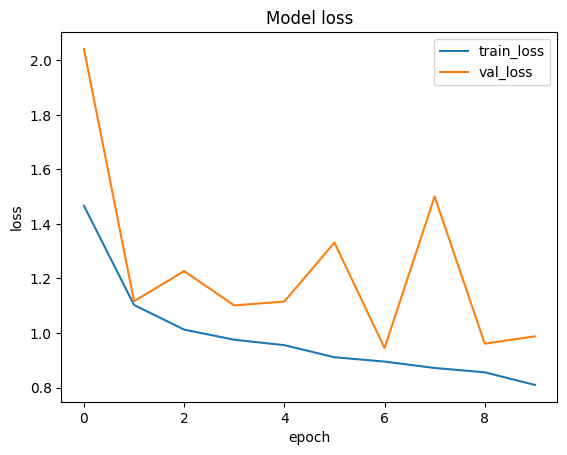

In [69]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

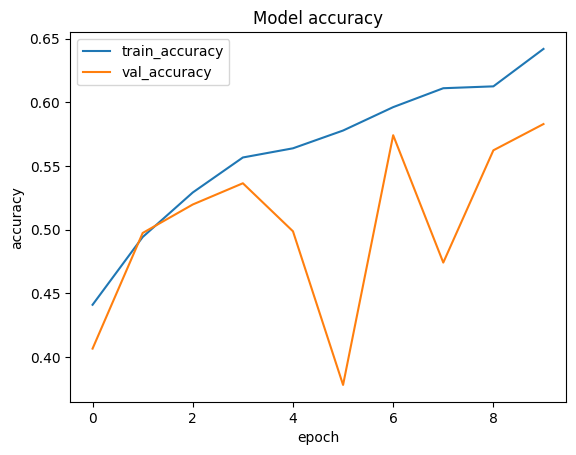

In [70]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [71]:
resnet_34.load_weights("best_weights")

In [72]:
resnet_34.evaluate(val_dataset)

72/72 [==============================] - 5s 63ms/step - loss: 0.9877 - accuracy: 0.5830


[0.987729549407959, 0.5829675197601318]

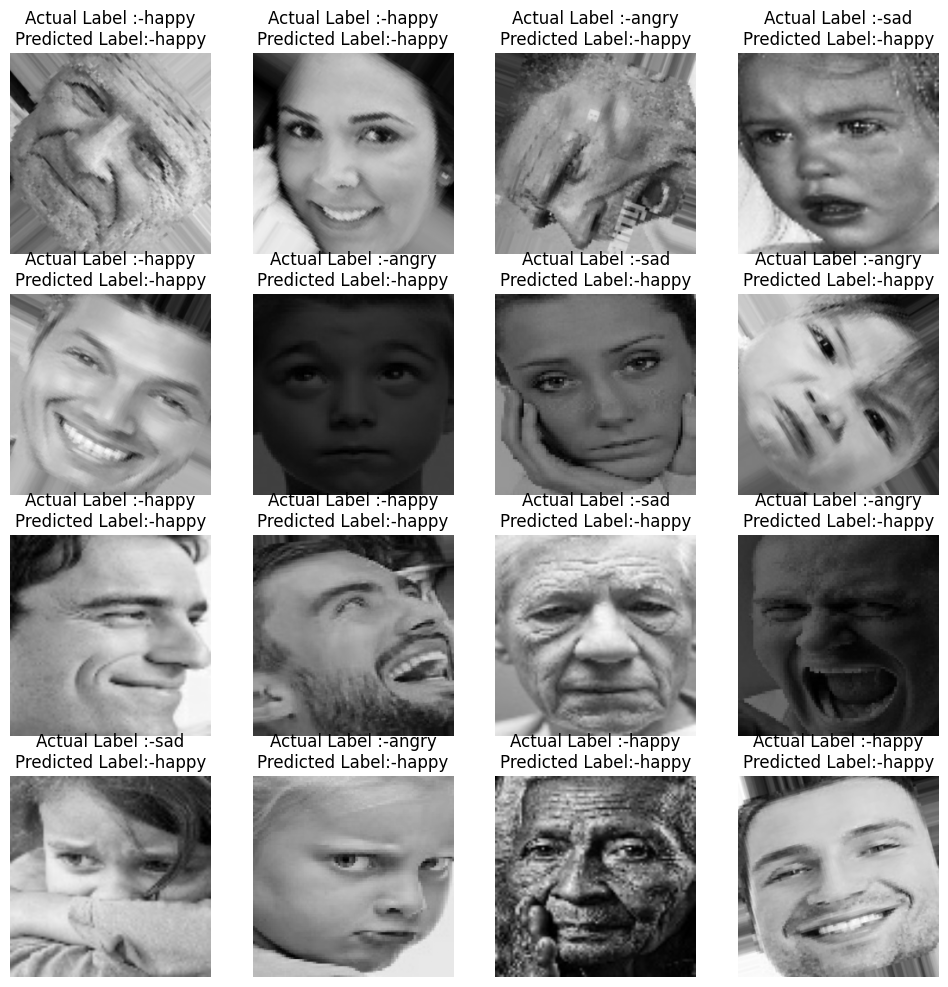

In [73]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(resnet_34(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [74]:
preds=[]
actual=[]

for im,label in val_dataset:
  actual.append(label.numpy())
  preds.append(lenet_model(im).numpy())

##**ConfusionMatrixDisplay**

In [75]:
resnet_34_preds=[]
resnet_34_actual=[]

for im,label in val_dataset:
  resnet_34_actual.append(label.numpy())
  resnet_34_preds.append(resnet_34(im).numpy())

In [76]:
print(np.argmax(resnet_34_preds[:-1],axis=-1).flatten())
print(np.argmax(resnet_34_actual[:-1],axis=-1).flatten())

[2 2 1 ... 0 1 2]
[1 0 1 ... 2 1 2]


In [77]:
resnet_34_preds=np.concatenate((np.argmax(resnet_34_preds[:-1],axis=-1).flatten(),(np.argmax(resnet_34_preds[-1],axis=-1).flatten())),axis=0)
resnet_34_labels=np.concatenate((np.argmax(resnet_34_actual[:-1],axis=-1).flatten(),np.argmax(resnet_34_actual[-1],axis=-1).flatten()),axis=0)

In [78]:

resnet_34_preds.shape

(2278,)

In [79]:
resnet_34_labels.shape

(2278,)

In [80]:
resnet_34_cm=confusion_matrix(resnet_34_labels,resnet_34_preds)
print(resnet_34_cm)

[[145 160 210]
 [ 28 801 177]
 [ 54 233 470]]


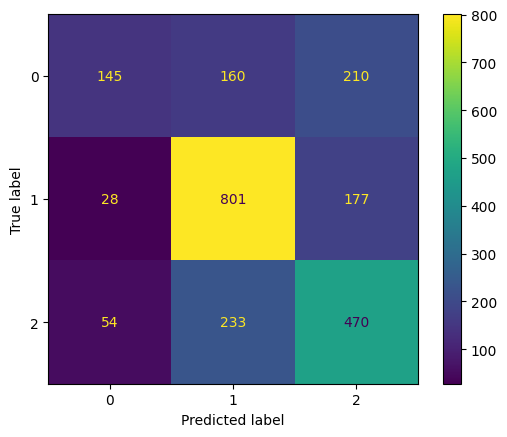

In [81]:
disp=ConfusionMatrixDisplay(resnet_34_cm)
disp.plot()
plt.show()

##**Create Model Using Transfer Learning**

In [82]:
base_model=tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"],3),
)

71686520/71686520 [==============================] - 3s 0us/step


In [83]:
base_model.trainable=False

In [84]:
model=tf.keras.Sequential([
    InputLayer(input_shape=(CONFIGURATION['IMG_SIZE'],CONFIGURATION['IMG_SIZE'],3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
])

In [85]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_40 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dense_9 (Dense)             (None, 3)                

In [86]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]*10),
                    metrics=["accuracy"])

In [87]:
for name,label in training_dataset.take(1):
  print(len(label))

32


In [88]:
history_4=model.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10
213/213 [==============================] - 75s 285ms/step - loss: 1.0091 - accuracy: 0.6554 - val_loss: 0.6693 - val_accuracy: 0.7147
Epoch 2/10
213/213 [==============================] - 56s 260ms/step - loss: 0.6315 - accuracy: 0.7217 - val_loss: 0.6173 - val_accuracy: 0.7485
Epoch 3/10
213/213 [==============================] - 56s 261ms/step - loss: 0.5969 - accuracy: 0.7423 - val_loss: 0.5412 - val_accuracy: 0.7629
Epoch 4/10
213/213 [==============================] - 56s 260ms/step - loss: 0.5460 - accuracy: 0.7594 - val_loss: 0.5581 - val_accuracy: 0.7766
Epoch 5/10
213/213 [==============================] - 56s 260ms/step - loss: 0.5166 - accuracy: 0.7745 - val_loss: 0.6107 - val_accuracy: 0.7603
Epoch 6/10
213/213 [==============================] - 55s 259ms/step - loss: 0.5063 - accuracy: 0.7894 - val_loss: 0.5620 - val_accuracy: 0.7704
Epoch 7/10
213/213 [==============================] - 56s 260ms/step - loss: 0.4904 - accuracy: 0.7984 - val_loss: 0.5388 - val_ac

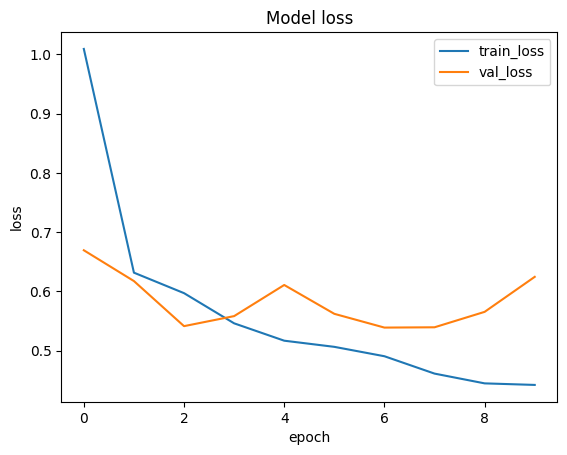

In [89]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

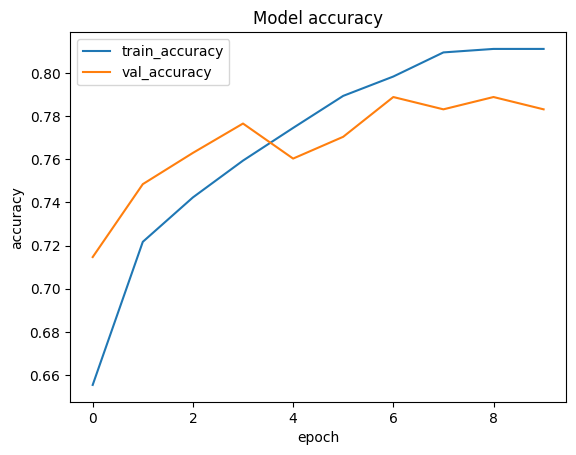

In [90]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [91]:
model.evaluate(val_dataset)

72/72 [==============================] - 14s 184ms/step - loss: 0.6244 - accuracy: 0.7831


[0.624406635761261, 0.7831431031227112]

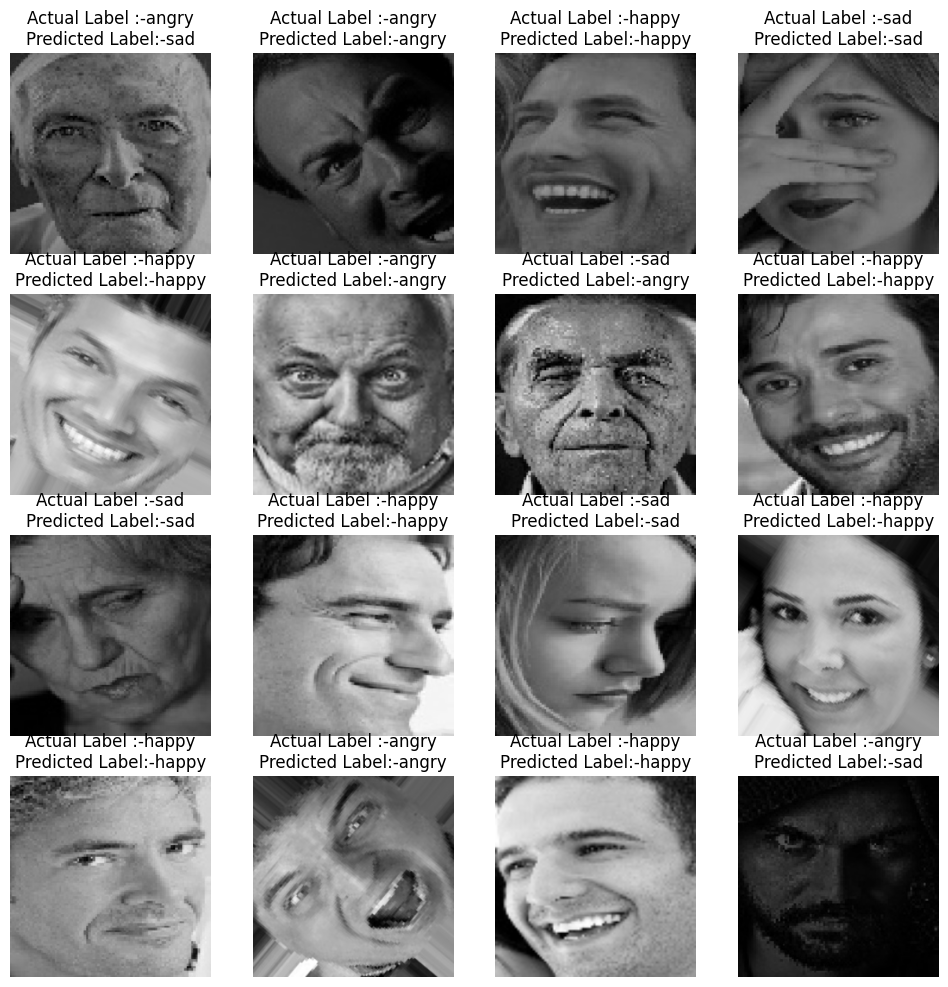

In [92]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(model(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [93]:
preds=[]
actual=[]

for im,label in val_dataset:
  actual.append(label.numpy())
  preds.append(model(im).numpy())

##**ConfusionMatrixDisplay**

In [94]:
model_preds=[]
model_actual=[]

for im,label in val_dataset:
  model_actual.append(label.numpy())
  model_preds.append(model(im).numpy())

In [95]:
print(np.argmax(model_preds[:-1],axis=-1).flatten())
print(np.argmax(model_actual[:-1],axis=-1).flatten())

[0 2 1 ... 0 2 0]
[0 2 1 ... 0 0 0]


In [96]:
model_preds=np.concatenate((np.argmax(model_preds[:-1],axis=-1).flatten(),(np.argmax(model_preds[-1],axis=-1).flatten())),axis=0)
model_labels=np.concatenate((np.argmax(model_actual[:-1],axis=-1).flatten(),np.argmax(model_actual[-1],axis=-1).flatten()),axis=0)

In [97]:

model_preds.shape

(2278,)

In [98]:
model_labels.shape

(2278,)

In [99]:
model_cm=confusion_matrix(model_labels,model_preds)
print(model_cm)

[[355  49 111]
 [ 53 858  95]
 [117  69 571]]


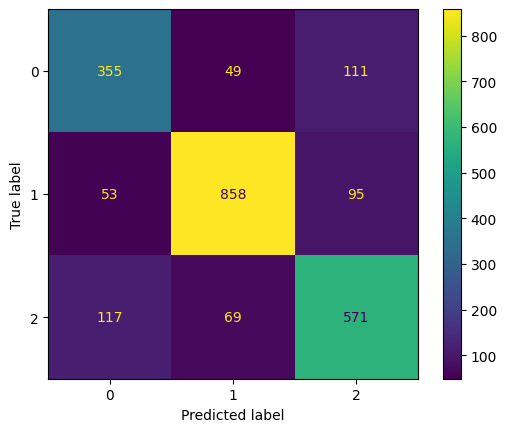

In [100]:
disp=ConfusionMatrixDisplay(model_cm)
disp.plot()
plt.show()

##**Fine Tune Model**

In [101]:
model.layers


In [102]:

for layer in model.layers:
  print(layer,layer.trainable)

<keras.engine.functional.Functional object at 0x7fdafb369870> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fdafb392920> True
<keras.layers.core.dense.Dense object at 0x7fd9e27439d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdafeb41d50> True
<keras.layers.core.dense.Dense object at 0x7fdafb4ab910> True
<keras.layers.core.dense.Dense object at 0x7fd9e53c02b0> True


In [103]:

for i,layer in enumerate(model.layers[0].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_reduce

In [104]:
print(len(model.layers[0].trainable_variables))

0


In [105]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [106]:
print(len(model.layers[0].trainable_variables))

10


In [107]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])


In [108]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)


0 input_3 False
1 rescaling_2 False
2 normalization False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_reduce

In [109]:
history_5=model.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1)

Epoch 1/10
213/213 [==============================] - 84s 315ms/step - loss: 0.4593 - accuracy: 0.8114 - val_loss: 0.5073 - val_accuracy: 0.8095
Epoch 2/10
213/213 [==============================] - 57s 265ms/step - loss: 0.3483 - accuracy: 0.8545 - val_loss: 0.4821 - val_accuracy: 0.8147
Epoch 3/10
213/213 [==============================] - 64s 300ms/step - loss: 0.3111 - accuracy: 0.8725 - val_loss: 0.5010 - val_accuracy: 0.8121
Epoch 4/10
213/213 [==============================] - 57s 265ms/step - loss: 0.2824 - accuracy: 0.8822 - val_loss: 0.4880 - val_accuracy: 0.8240
Epoch 5/10
213/213 [==============================] - 64s 298ms/step - loss: 0.2609 - accuracy: 0.8904 - val_loss: 0.4587 - val_accuracy: 0.8301
Epoch 6/10
213/213 [==============================] - 56s 263ms/step - loss: 0.2342 - accuracy: 0.9041 - val_loss: 0.4552 - val_accuracy: 0.8376
Epoch 7/10
213/213 [==============================] - 56s 263ms/step - loss: 0.2216 - accuracy: 0.9087 - val_loss: 0.4911 - val_ac

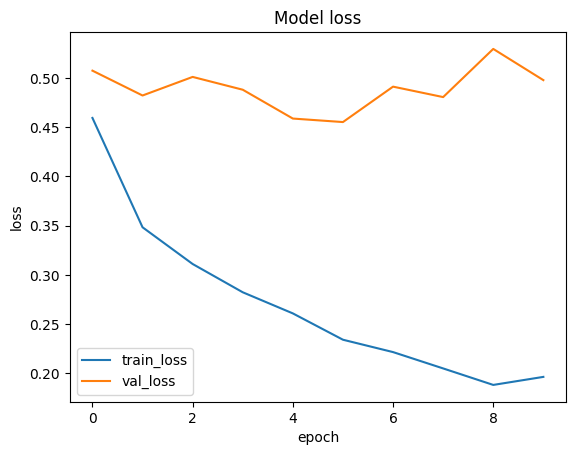

In [110]:
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

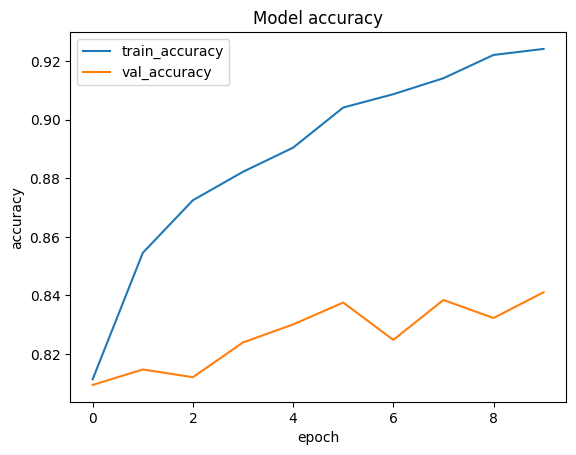

In [111]:
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [112]:
model.evaluate(val_dataset)

72/72 [==============================] - 14s 184ms/step - loss: 0.4977 - accuracy: 0.8411


[0.4977170526981354, 0.8410886526107788]

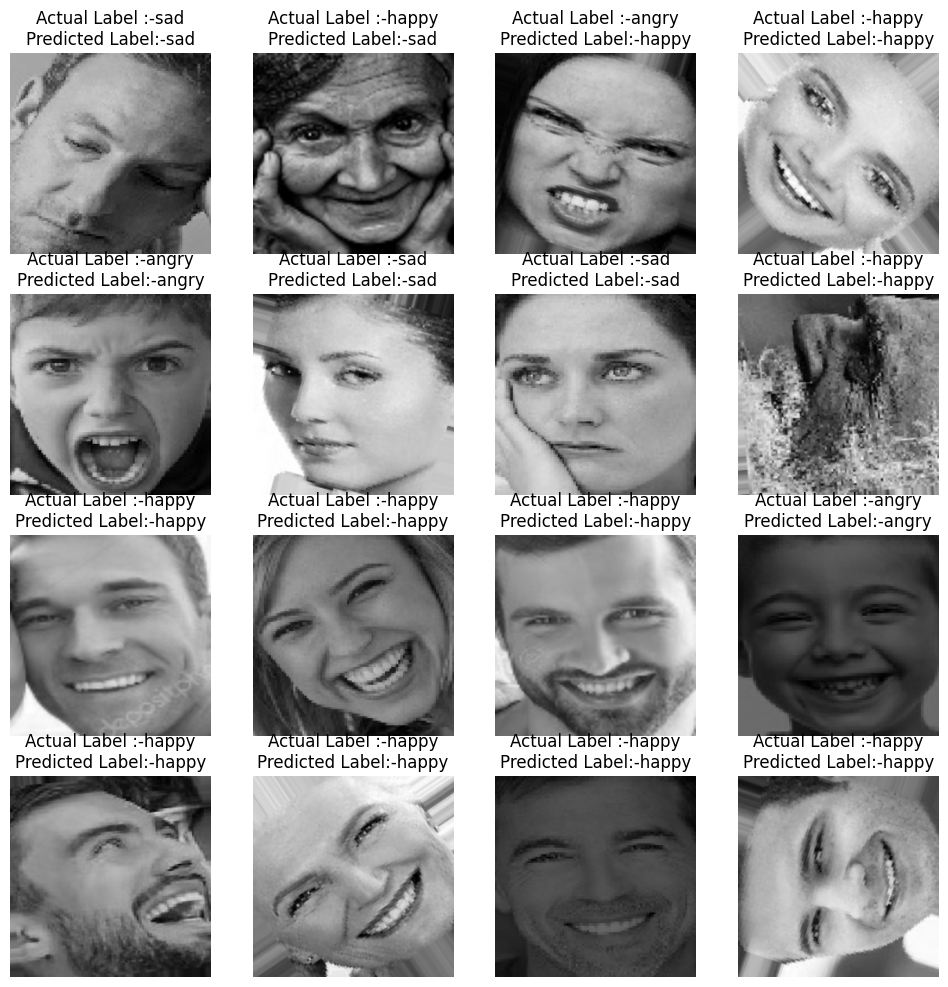

In [113]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(model(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [114]:
model_preds=[]
model_actual=[]

for im,label in val_dataset:
  model_actual.append(label.numpy())
  model_preds.append(model(im).numpy())

In [115]:
print(np.argmax(model_preds[:-1],axis=-1).flatten())
print(np.argmax(model_actual[:-1],axis=-1).flatten())

[0 2 2 ... 1 1 2]
[0 1 1 ... 1 1 0]


In [116]:
model_preds=np.concatenate((np.argmax(model_preds[:-1],axis=-1).flatten(),(np.argmax(model_preds[-1],axis=-1).flatten())),axis=0)
model_labels=np.concatenate((np.argmax(model_actual[:-1],axis=-1).flatten(),np.argmax(model_actual[-1],axis=-1).flatten()),axis=0)

In [117]:

model_preds.shape

(2278,)

In [118]:
model_labels.shape

(2278,)

In [119]:
model_cm=confusion_matrix(model_labels,model_preds)
print(model_cm)

[[383  37  95]
 [ 30 885  91]
 [ 50  59 648]]


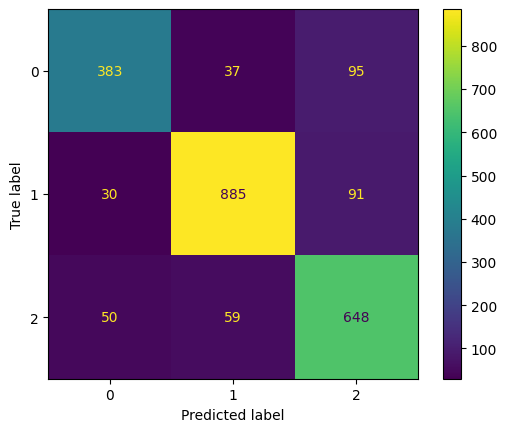

In [120]:
disp=ConfusionMatrixDisplay(model_cm)
disp.plot()
plt.show()

##**Ensemble Model And Class Imbalance**

In [122]:
inputs = tf.keras.layers.Input(shape = (CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"], 3))

y_1 = resnet_34(inputs)
y_2 = model(inputs)

output = 0.5*y_1 + 0.5*y_1

ensemble_model = tf.keras.Model(inputs = inputs, outputs = output)

## Class Weighting

In [123]:
n_sample_0 = 1525 # angry
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad


In [124]:
class_weights = {0:6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}

In [125]:
print(class_weights)

{0: 4.458360655737705, 1: 2.2520702219277906, 2: 3.015077605321508}


In [126]:
resnet_34.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(CONFIGURATION["LEARNING_RATE"]*10),
                    metrics=["accuracy"])

In [127]:
for name,label in training_dataset.take(1):
  print(len(label))

32


In [128]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_weights', 
    monitor='val_accuracy',
    mode = 'max',
    verbose=1, 
    class_weight = class_weights,
    
    )

In [130]:
history_7=resnet_34.fit(training_dataset,
                          validation_data=val_dataset,
                          epochs=10,
                          verbose=1,
                          callbacks=[checkpoint_callback])

Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 0.6215 - accuracy: 0.7355
Epoch 1: saving model to best_weights


213/213 [==============================] - 67s 315ms/step - loss: 0.6215 - accuracy: 0.7355 - val_loss: 2.1841 - val_accuracy: 0.5768
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.7619
Epoch 2: saving model to best_weights


213/213 [==============================] - 66s 308ms/step - loss: 0.5532 - accuracy: 0.7619 - val_loss: 1.3946 - val_accuracy: 0.5838
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 0.4943 - accuracy: 0.7919
Epoch 3: saving model to best_weights


213/213 [==============================] - 67s 313ms/step - loss: 0.4943 - accuracy: 0.7919 - val_loss: 0.9863 - val_accuracy: 0.6418
Epoch 4/10
213/213 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8281
Epoch 4: saving model to best_weights


213/213 [==============================] - 71s 334ms/step - loss: 0.4212 - accuracy: 0.8281 - val_loss: 3.1502 - val_accuracy: 0.6387
Epoch 5/10
213/213 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8594
Epoch 5: saving model to best_weights


213/213 [==============================] - 70s 327ms/step - loss: 0.3515 - accuracy: 0.8594 - val_loss: 4.7898 - val_accuracy: 0.5777
Epoch 6/10
213/213 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8773
Epoch 6: saving model to best_weights


213/213 [==============================] - 72s 337ms/step - loss: 0.3117 - accuracy: 0.8773 - val_loss: 0.9782 - val_accuracy: 0.6940
Epoch 7/10
213/213 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9028
Epoch 7: saving model to best_weights


213/213 [==============================] - 72s 339ms/step - loss: 0.2466 - accuracy: 0.9028 - val_loss: 1.3585 - val_accuracy: 0.6962
Epoch 8/10
213/213 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9159
Epoch 8: saving model to best_weights


213/213 [==============================] - 67s 315ms/step - loss: 0.2140 - accuracy: 0.9159 - val_loss: 3.4426 - val_accuracy: 0.7112
Epoch 9/10
213/213 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9362
Epoch 9: saving model to best_weights


213/213 [==============================] - 72s 335ms/step - loss: 0.1740 - accuracy: 0.9362 - val_loss: 0.8244 - val_accuracy: 0.7616
Epoch 10/10
213/213 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9394
Epoch 10: saving model to best_weights


213/213 [==============================] - 67s 312ms/step - loss: 0.1671 - accuracy: 0.9394 - val_loss: 1.8389 - val_accuracy: 0.6348


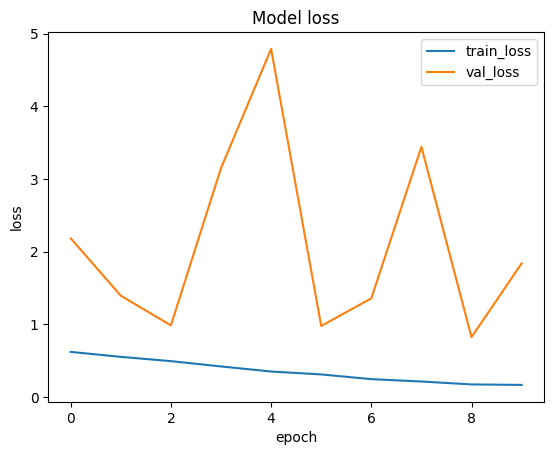

In [131]:
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

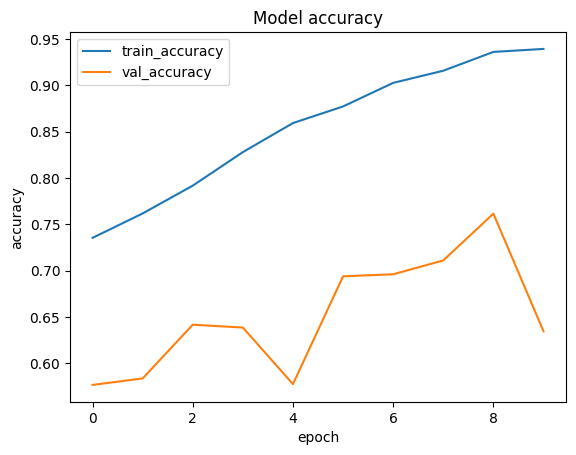

In [132]:
plt.plot(history_7.history['accuracy'])
plt.plot(history_7.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [133]:
resnet_34.evaluate(val_dataset)

72/72 [==============================] - 5s 66ms/step - loss: 1.8389 - accuracy: 0.6348


[1.8388594388961792, 0.6347673535346985]

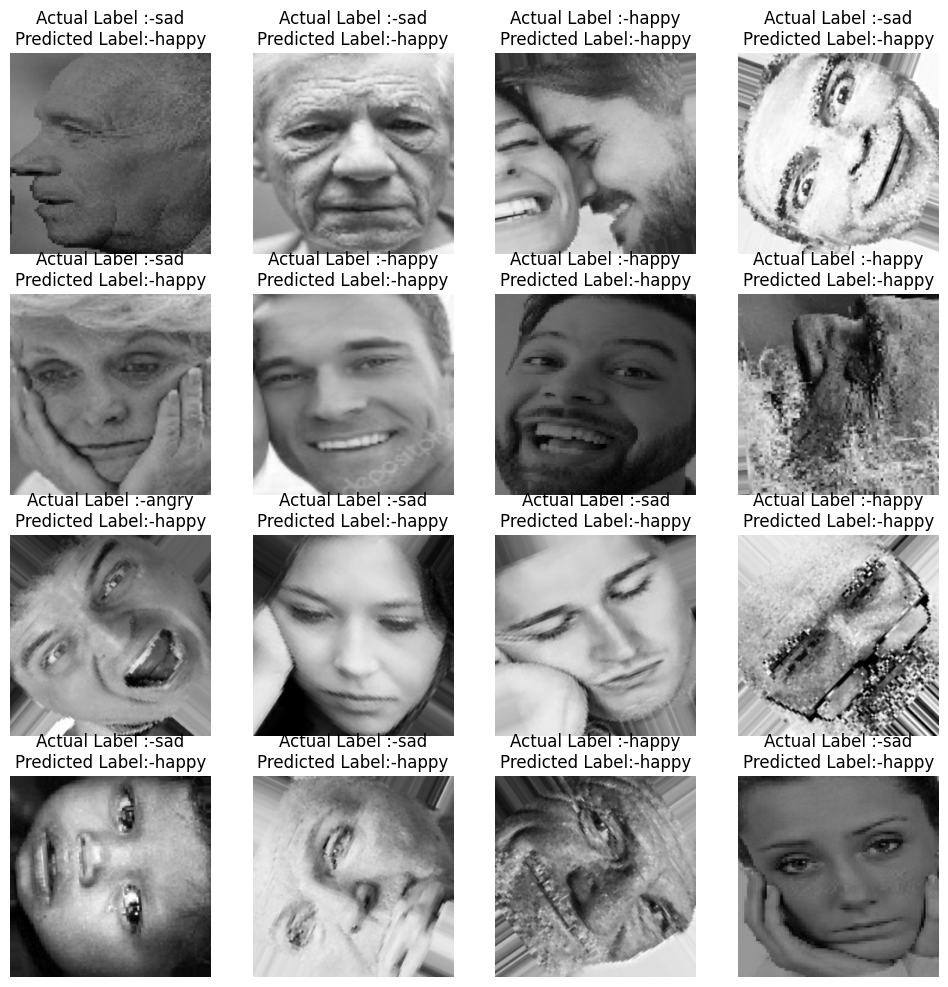

In [134]:
plt.figure(figsize=(12,12))
for image,labels in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title("Actual Label :-" + CLASS_NAME[tf.argmax(labels[i],axis=-1).numpy()] + '\n' + "Predicted Label:-" + CLASS_NAME[tf.argmax(resnet_34(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis("off")

##**ConfusionMatrixDisplay**

In [135]:
resnet_34_preds=[]
resnet_34_actual=[]

for im,label in val_dataset:
  resnet_34_actual.append(label.numpy())
  resnet_34_preds.append(resnet_34(im).numpy())

In [136]:
print(np.argmax(resnet_34_preds[:-1],axis=-1).flatten())
print(np.argmax(resnet_34_actual[:-1],axis=-1).flatten())

[1 2 1 ... 0 2 1]
[1 2 1 ... 2 2 0]


In [137]:
resnet_34_preds=np.concatenate((np.argmax(resnet_34_preds[:-1],axis=-1).flatten(),(np.argmax(resnet_34_preds[-1],axis=-1).flatten())),axis=0)
resnet_34_labels=np.concatenate((np.argmax(resnet_34_actual[:-1],axis=-1).flatten(),np.argmax(resnet_34_actual[-1],axis=-1).flatten()),axis=0)

In [138]:

resnet_34_preds.shape

(2278,)

In [139]:
resnet_34_labels.shape

(2278,)

In [140]:
resnet_34_cm=confusion_matrix(resnet_34_labels,resnet_34_preds)
print(resnet_34_cm)

[[350  53 112]
 [ 41 876  89]
 [ 84  90 583]]


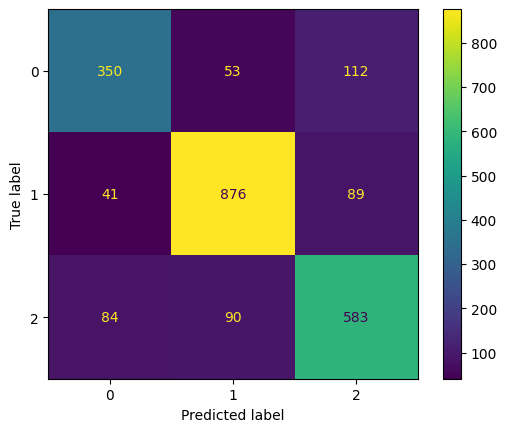

In [141]:
disp=ConfusionMatrixDisplay(resnet_34_cm)
disp.plot()
plt.show()